In [1]:
# library imports

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional, Input, SpatialDropout1D
import datetime
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from tensorflow.keras.layers.embeddings import Embedding


In [2]:
# reading the dataset

df = pd.read_csv('movie_data.csv')
df.head(10)

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1
5,"I saw this film on September 1st, 2005 in Indi...",1
6,"Maybe I'm reading into this too much, but I wo...",1
7,I felt this film did have many good qualities....,1
8,This movie is amazing because the fact that th...,1
9,"""Quitting"" may be as much about exiting a pre-...",1


In [3]:
# Splitting the dataset: 80% for the training dataset, 10% for the validating dataset, 10% for the testing dataset

X = df.loc[:44999, 'review'].values
y = df.loc[:44999, 'sentiment'].values
# X_test = df.loc[45000:, 'review'].values
# y_test = df.loc[45000:,'sentiment'].values
# X_val = df.loc[40000:44999, 'review'].values
# y_val = df.loc[40000:44999, 'sentiment'].values
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.1111, random_state = 50)
# X_train = X_train[:20000,]
# y_train = y_train[:20000,]
# X_val = X_val[:2500,]
# y_val = y_val[:2500,]
print(X_train.shape)
print(X_val.shape)

(40000,)
(5000,)


In [4]:
tokenizer_obj = Tokenizer()
total_reviews = np.concatenate((X_train, X_val), axis = 0)
tokenizer_obj.fit_on_texts(total_reviews) 

# zero-padding the sequences so that all the vectors in the dataset have the same length. 
# Normally, this parameter should be equal to the length of the longest review, but due to
# the lack of necessary computational power I set this parameter to a lower value.  

max_length = 100
real_max_length = max([len(s.split()) for s in total_reviews])

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens =  tokenizer_obj.texts_to_sequences(X_train)
X_val_tokens = tokenizer_obj.texts_to_sequences(X_val)

x_train = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
x_val = pad_sequences(X_val_tokens, maxlen=max_length, padding='post')


print('Actual max length: ', real_max_length)
print('Vocabulary size: ', vocab_size)

Actual max length:  2470
Vocabulary size:  118334


In [5]:
# Now let's build our model following the proposed architecture: Embedding layer -> recurrent layer -> Dense layer 

def get_model():
    model = tf.keras.models.Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(SpatialDropout1D(0.4))
    model.add(GRU(units=64,  dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    # model = tf.keras.Model(inputs=first_layer, outputs=third_layer)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    
    model.summary()
    return model


In [6]:
def get_callbacks():
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience= 2, mode='min', restore_best_weights=True)
#     log_dir = "log/log" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#     tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    return early_stopping

In [7]:
model = get_model()
history = model.fit(x_train, y_train, batch_size=256, epochs=20, callbacks=get_callbacks(),
          validation_data=(x_val, y_val))

2021-09-22 22:18:09.709114: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-09-22 22:18:09.785092: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Quadro M4000 computeCapability: 5.2
coreClock: 0.7725GHz coreCount: 13 deviceMemorySize: 7.94GiB deviceMemoryBandwidth: 179.11GiB/s
2021-09-22 22:18:09.785639: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-09-22 22:18:09.789216: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-09-22 22:18:09.791993: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-09-22 22:18:09.792495: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
202

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          11833400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 100)          0         
_________________________________________________________________
gru (GRU)                    (None, 64)                31872     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 11,865,337
Trainable params: 11,865,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


2021-09-22 22:18:13.037237: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


157/157 [==============================] - 46s 291ms/step - loss: 0.5158 - accuracy: 0.7257 - val_loss: 0.3268 - val_accuracy: 0.8596
Epoch 2/20
157/157 [==============================] - 45s 290ms/step - loss: 0.2734 - accuracy: 0.8887 - val_loss: 0.3065 - val_accuracy: 0.8696
Epoch 3/20
157/157 [==============================] - 45s 289ms/step - loss: 0.1898 - accuracy: 0.9296 - val_loss: 0.3851 - val_accuracy: 0.8574
Epoch 4/20
157/157 [==============================] - 45s 286ms/step - loss: 0.1372 - accuracy: 0.9510 - val_loss: 0.3825 - val_accuracy: 0.8578


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


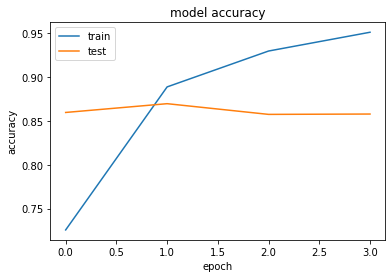

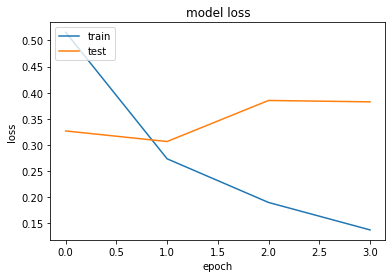

In [8]:
# history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
# Results are pretty good for a simple network. 

print('Testing...')
x_test = df.loc[45000:, 'review'].values
y_test = df.loc[45000:, 'sentiment'].values
x_test = tokenizer_obj.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=max_length, padding='post')
score, acc = model.evaluate(x_test, y_test, batch_size=128)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

Testing...
40/40 [==============================] - 1s 23ms/step - loss: 0.3891 - accuracy: 0.8214
Test score: 0.3891104459762573
Test accuracy: 0.821399986743927
Accuracy: 82.14%


Not bad for a simple network which also features overfit. 

In [10]:
#Let's test the network using some simple reviews 

test_sample_1 = "This movie is fantastic! I really like it because it is so good!"
test_sample_2 = "Good movie!"
test_sample_3 = "Maybe I like this movie."
test_sample_4 = "if you like action, then this movie might be good for you."
test_sample_5 = "Not to my taste, will skip and watch another movie"
test_sample_6 = "Terrible movie!"
test_sample_7 = "This movie really sucks! Can I get my money back please?"
test_samples = [test_sample_1, test_sample_2, test_sample_3, test_sample_4, test_sample_5, test_sample_6, test_sample_7]

test_samples_tokens = tokenizer_obj.texts_to_sequences(test_samples)
test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=20)

#predict
model.predict(x=test_samples_tokens_pad)


array([[0.8516024 ],
       [0.5754619 ],
       [0.4489088 ],
       [0.6807832 ],
       [0.13996276],
       [0.10306962],
       [0.11184629]], dtype=float32)

In [13]:
# Let's try a different approach, using a different architecture: Embedding Layer -> 2 Bidirectional LSTM Layers ->
# Dense layer


# We'll use the same embedding dimension for each integer
model_2 = tf.keras.models.Sequential()
model_2.add(Embedding(vocab_size, 100, input_length = max_length))
model_2.add(SpatialDropout1D(0.4))
# Add 2 bidirectional LSTMs with dropout to prevent overfitting
model_2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
#
model_2.add(Dense(1, activation="sigmoid"))
# model_2 = tf.keras.Model(inputs, outputs)
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          11833400  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 100)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 12,016,825
Trainable params: 12,016,825
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_2 = model_2.fit(x_train, y_train, batch_size=256, epochs=20, callbacks=get_callbacks(),
          validation_data=(x_val, y_val))

Epoch 1/20
157/157 [==============================] - 157s 1s/step - loss: 0.4284 - accuracy: 0.7874 - val_loss: 0.3058 - val_accuracy: 0.8700
Epoch 2/20
157/157 [==============================] - 155s 986ms/step - loss: 0.2368 - accuracy: 0.9067 - val_loss: 0.3174 - val_accuracy: 0.8656
Epoch 3/20
157/157 [==============================] - 156s 996ms/step - loss: 0.1536 - accuracy: 0.9425 - val_loss: 0.3539 - val_accuracy: 0.8654


In [16]:
#Let's test the network using the same reviews 
score, acc = model_2.evaluate(x_test, y_test, batch_size=128)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))
model_2.predict(x=test_samples_tokens_pad)


40/40 [==============================] - 3s 83ms/step - loss: 0.3585 - accuracy: 0.8444
Test score: 0.3585328161716461
Test accuracy: 0.8443999886512756
Accuracy: 84.44%


array([[0.8943997 ],
       [0.44844666],
       [0.31360254],
       [0.5546446 ],
       [0.15966246],
       [0.11573896],
       [0.08985393]], dtype=float32)

The performances of the two networks are similar.